In [2]:
import os
from pathlib import Path
from pnpl.datasets.libribrain2025 import constants_utils

constants_utils.set_remote_constants_url(
    f"{(Path(os.getcwd()) / 'constants.json').as_uri()}")
constants_utils.refresh_constants();

In [3]:
from pnpl.datasets import LibriBrainPhoneme
from libribrain_experiments.grouped_dataset import MyGroupedDatasetV3

_train_dataset = LibriBrainPhoneme(
    data_path="./data/",
    tmin=0.0,
    tmax=0.5,
    standardize=True,
    partition="train",
)

train_dataset = MyGroupedDatasetV3(
    _train_dataset,
    grouped_samples=100,
    drop_remaining=False,
    average_grouped_samples=True,
    state_cache_path=Path(
        "./data_preprocessed/groupedv3/train_grouped_100.pt"),
    shuffle=True,
    # augment=True,  # Set to True if you want to apply data augmentation
)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.signal import stft
from torch import stft

In [5]:
labels = _train_dataset.labels_sorted

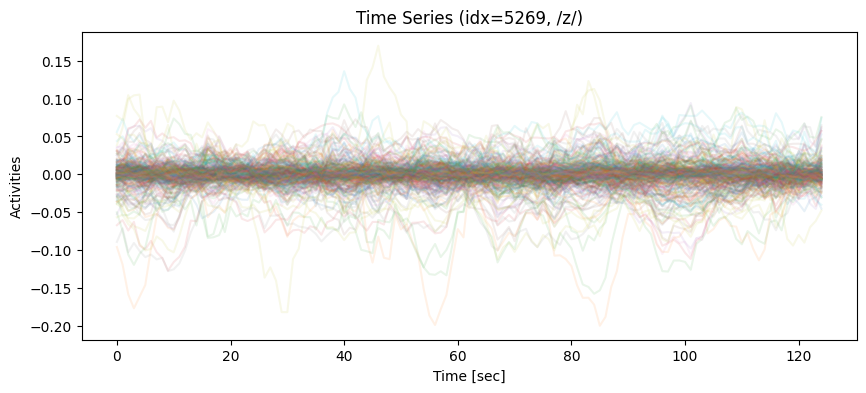

In [6]:
def plot_channels(dataset, sr=1000, n_fft=256, hop_length=128):
    data_index = np.random.randint(len(dataset))
    data0 = dataset[data_index]
    X = data0[0]
    y = data0[1]
    label = labels[y]

    TIME_X = True

    plt.figure(figsize=(10, 4))
    plt.plot(X.T if TIME_X else X, alpha=0.1)
    plt.title(f'Time Series (idx={data_index}, /{label}/)')
    plt.ylabel('Activities')
    plt.xlabel('Time [sec]' if TIME_X else 'Channels')
    plt.show()


plot_channels(train_dataset)

In [13]:
import cProfile
import pstats
from torch.utils.data import DataLoader

from tqdm import tqdm

def to_spectrogram(dataset, sr=250, n_fft=26, hop_length=10):
    # data_index = np.random.randint(len(dataset))
    loader = DataLoader(dataset, batch_size=64)
    for idx, data0 in tqdm(enumerate(loader), total=len(loader)):
        X = data0[0]

        print(X.shape)

        X = X.view(-1, 125)  # (N * 306, num_samples=125)

        print(X.shape)

        # f, t, Zxx = stft(X.T, fs=sr, nperseg=n_fft, noverlap=n_fft - hop_length)
        freq_bins = n_fft // 2 + 1
        time_bins = 1 + (X.shape[1] - n_fft) // hop_length
        Zxx = stft(X, n_fft=n_fft, hop_length=hop_length, return_complex=True)

        print(Zxx.shape)  # (N * 306, freq_bins=14, time_bins=14)
        Sxx = np.abs(Zxx)

        Sxx = Sxx.reshape(-1, 306, freq_bins, time_bins)  # (N, 306, freq_bins, time_bins)

        if idx >= 5:
            break
    return Sxx

to_spectrogram(train_dataset).shape
# cProfile.runctx('to_spectrogram(train_dataset)', globals(), locals(), 'Profile.prof')
# p = pstats.Stats('Profile.prof')
# print(p.strip_dirs().sort_stats("cumulative").print_stats())

  0%|          | 0/210 [00:00<?, ?it/s]/tmp/ipykernel_3704167/2469099902.py:25: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Sxx = np.abs(Zxx)
  0%|          | 0/210 [00:00<?, ?it/s]

torch.Size([64, 306, 125])
torch.Size([19584, 125])
torch.Size([19584, 14, 13])


RuntimeError: shape '[-1, 306, 14, 10]' is invalid for input of size 3564288

In [15]:
import plotly.graph_objects as go

def plot_spectrogram(dataset, sr=250, n_fft=26, hop_length=10):
    # sample rate = 250 Hz
    # n_fft = 25 (100 ms)
    # hop_length = 10 (40 ms)
    data_index = np.random.randint(len(dataset))
    data0 = dataset[data_index]
    X = data0[0]
    y = data0[1]
    label = labels[y]

    f, t, Zxx = stft(X, fs=sr, nperseg=n_fft, noverlap=n_fft - hop_length)
    print(f.shape, t.shape, Zxx.shape)
    
    # Default channel
    channel = 0
    
    fig = go.Figure(data=go.Heatmap(
        z=np.abs(Zxx[channel]),
        x=t,
        y=f,
        colorscale='Viridis'
    ), layout=dict(height=800, width=1000))
    
    # Add dropdown for channel selection
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(
                        label="Freq vs Time",
                        method="update",
                        args=[
                            {"z": [np.abs(Zxx[0, :, :])], "y": [f], "x": [t]},
                            {
                                "sliders": [dict(
                                    active=0,
                                    steps=[
                                        dict(
                                            method='restyle',
                                            args=[{'z': [np.abs(Zxx[ch, :, :])]}],
                                            label=f'Channel {ch}'
                                        ) for ch in range(Zxx.shape[0])
                                    ],
                                    currentvalue={"prefix": "Channel: "},
                                    pad={"t": 50},
                                )],
                                "yaxis_title": "Frequency [Hz]",
                                "title": f'Spectrogram (idx={data_index}, /{label}/) - Freq vs Time'
                            }
                        ]
                    ),
                    dict(
                        label="Time vs Channel",
                        method="update",
                        args=[
                            {"z": [np.abs(Zxx[:, 0, :]).T], "x": [list(range(Zxx.shape[0]))], "y": [t]},
                            {
                                "sliders": [dict(
                                    active=0,
                                    steps=[
                                        dict(
                                            method='restyle',
                                            args=[{'z': [np.abs(Zxx[:, fi, :]).T]}],
                                            label=f'Freq {f[fi]:.1f} Hz'
                                        ) for fi in range(Zxx.shape[1])
                                    ],
                                    currentvalue={"prefix": "Freq: "},
                                    pad={"t": 50},
                                )],
                                "xaxis_title": "Channel",
                                "yaxis_title": "Time [sec]",
                                "title": f'Spectrogram (idx={data_index}, /{label}/) - Time vs Channel'
                            }
                        ]
                    )
                ],
                direction="down",
                showactive=True,
                pad={"r": 10, "t": 10},
                x=0.1,
                xanchor="left",
                y=1.1,
                yanchor="top"
            )
        ],
        sliders=[dict(
            active=0,
            steps=[
                dict(
                    method='restyle',
                    args=[{'z': [np.abs(Zxx[ch])]}],
                    label=f'Channel {ch}'
                ) for ch in range(Zxx.shape[0])
            ],
            currentvalue={"prefix": "Channel: "},
            pad={"t": 50},
        )],
        title=f'Spectrogram (idx={data_index}, /{label}/)',
        xaxis_title='Time [sec]',
        yaxis_title='Frequency [Hz]'
    )
    
    fig.show()

plot_spectrogram(train_dataset, n_fft=14)

(8,) (14,) (306, 8, 14)


In [16]:
data0 = train_dataset[0]
X = data0[0]
y = data0[1]
print(X.shape, y.shape)

torch.Size([306, 125]) torch.Size([])


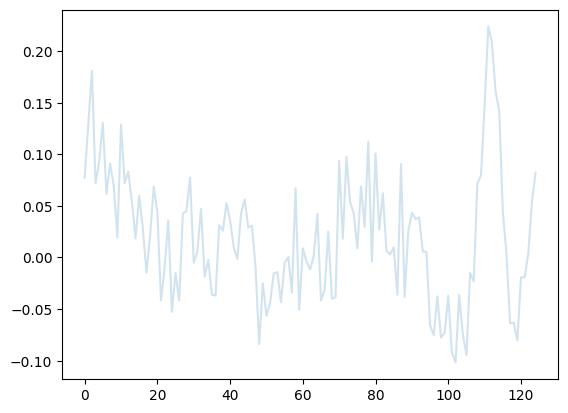

In [15]:
plt.plot(data0[0][0], alpha=0.2);
